In [1]:
from plotnine import *
import pandas
from solarized import *
import tikzplotlib
pandas.options.display.max_rows=10

In [2]:
# 1.{5end_to_end} tpch 1,2,3,4,5 with scale 1, 10
# 2 {5module4} and 3. module4 | also {5module4mem} and {5module4net}
# 3.{5tpchmodin} tpch 1, 4, 5 with modin on scale 10
# 4.{5micro_scales} micros with scale 1, 10 | also {5micro_traffic}
# 5.{5micro_net} micro join, selection with net=wan and scale 1

In [4]:
factors= ['wflow', 'optimizer', 'net', 'scale']
df=pandas.read_feather('specific-reports/5micro_scales.feather')
df.columns

Index(['bytes_memory', 'cpu_percent', 'bytes_sent', 'bytes_recv',
       'snapshot_idx', 'proc_time', 'exitcode', 'db_time', 'shared_wall_time',
       'wflow', 'optimizer', 'scale', 'net'],
      dtype='object')

# CHECK

In [5]:
df['exitcode'].value_counts()

 0     35673
-15     4461
Name: exitcode, dtype: int64

In [9]:
df.query("exitcode != 0")['wflow'].unique()

array(['micro_join.py'], dtype=object)

In [11]:
df.query("exitcode != 0")['optimizer'].unique()

array(['optimized'], dtype=object)

# PREPROCESS

In [32]:
df['gb_net'] = df['bytes_recv']/10**9

In [41]:
overview = df.groupby(by=factors).first().reset_index()
print(overview.columns)
overview = overview[["wflow", "optimizer", "scale", "shared_wall_time", "proc_time", "gb_net"]]

Index(['wflow', 'optimizer', 'net', 'scale', 'bytes_memory', 'cpu_percent',
       'bytes_sent', 'bytes_recv', 'snapshot_idx', 'proc_time', 'exitcode',
       'db_time', 'shared_wall_time', 'gb_net'],
      dtype='object')


In [42]:
plot_df = overview

In [43]:
plot_df["scale"] = plot_df["scale"].replace(1, "scale 1")
plot_df["scale"] = plot_df["scale"].replace(10, "scale 10")
plot_df["wflow"] = plot_df["wflow"].replace("micro_join.py", "join")
plot_df["wflow"] = plot_df["wflow"].replace("micro_sel.py", "sel")
plot_df["wflow"] = plot_df["wflow"].replace("micro_proj.py", "proj")
plot_df["wflow"] = plot_df["wflow"].replace("micro_max.py", "max")

# {5micro_scales}

In [44]:
plot = (
        ggplot(plot_df, aes('wflow', y='shared_wall_time', fill='optimizer'))
        + geom_col(width = 0.5, position = "dodge")
        #+ scale_fill_manual(values=cdict) 
        + scale_y_sqrt()
        + labs(fill="Optimization Method")
        + facet_wrap('~ scale', scales='free_y', nrow=1, dir='v')
        + xlab("Query")
        + ylab("Time (in sec.)")
       # + theme(figure_size=(8, 2))
               #subplots_adjust={'hspace': 1, 'wspace': 0.25})
        + theme(figure_size=(8, 2), subplots_adjust={'wspace': 0.20})
    )

E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 8 x 2 in image.
E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: specific-plots/5micro_scales.png
E:\ssdapps\anaconda\lib\site-packages\tikzplotlib\_save.py:390: UserWarning: tikzplotlib: Don't know how to handle object <class 'matplotlib.offsetbox.AnchoredOffsetbox'>.


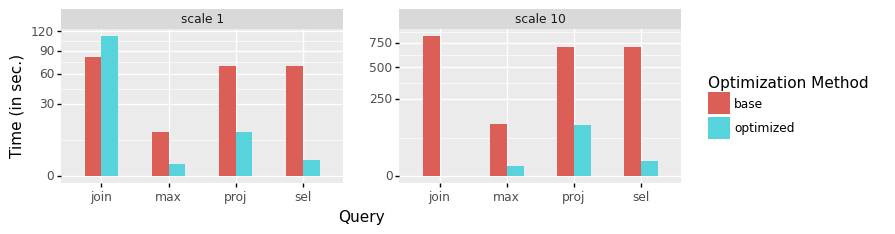

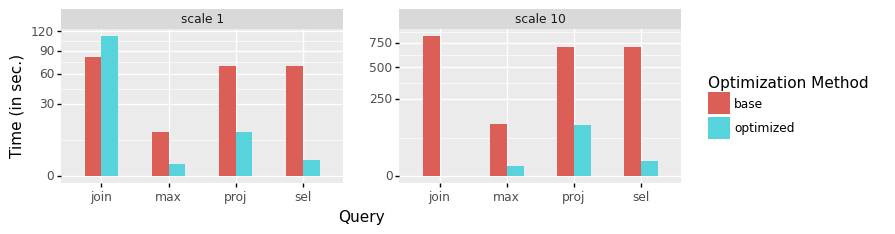

<ggplot: (150282649866)>

In [45]:
plot.save("specific-plots/5micro_scales.png")
matplot = plot.draw()
tikzplotlib.save('specific-plots/5micro_scales.tikz', figure=matplot)
display(plot)

In [46]:
overview.query("scale =='scale 10' and wflow =='join'")

,wflow,optimizer,scale,shared_wall_time,proc_time,gb_net
1,join,base,scale 10,827.086853,844.001867,14.839955
3,join,optimized,scale 10,0.000000,358.790700,21.539664


# {5micro_traffic}

In [67]:
plot = (
        ggplot(plot_df, aes('wflow', y='gb_net', fill='optimizer'))
        + geom_col(width = 0.5, position = "dodge")
        #+ scale_fill_manual(values=cdict) 
        + scale_y_sqrt()
        + labs(fill="Optimization Method")
        + facet_wrap('~ scale', scales='free_x', nrow=1, dir='v')
        + xlab("Query")
        + ylab("Network Transfer (in GB)")
       # + theme(figure_size=(8, 2))
               #subplots_adjust={'hspace': 1, 'wspace': 0.25})
        + coord_flip()
        + theme(figure_size=(8, 2)#, subplots_adjust={'wspace': 0.20}
               )
    )

E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 8 x 2 in image.
E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: specific-plots/5micro_traffic.png
E:\ssdapps\anaconda\lib\site-packages\tikzplotlib\_save.py:390: UserWarning: tikzplotlib: Don't know how to handle object <class 'matplotlib.offsetbox.AnchoredOffsetbox'>.


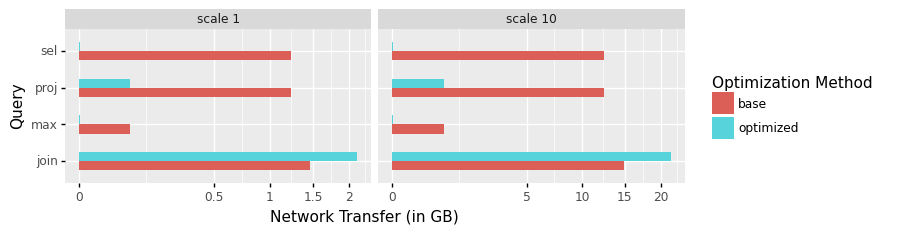

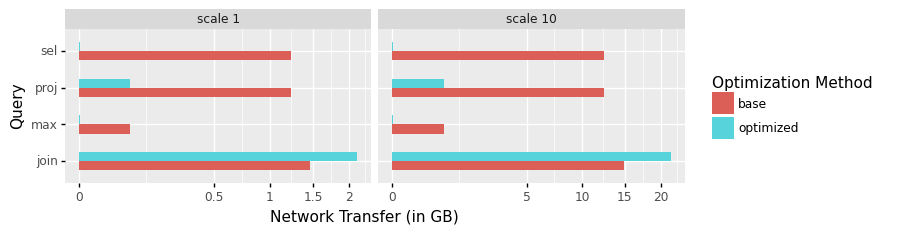

<ggplot: (150282647411)>

In [68]:
plot.save("specific-plots/5micro_traffic.png")
matplot = plot.draw()
tikzplotlib.save('specific-plots/5micro_traffic.tikz', figure=matplot)
display(plot)

In [58]:
plot_df.query("""scale=='scale 1' and wflow=='sel'""")

,wflow,optimizer,scale,shared_wall_time,proc_time,gb_net
12,sel,base,scale 1,68.794243,70.018200,1.229107
14,sel,optimized,scale 1,1.383998,1.477111,0.000017


, pushing down the inner join operation worsened performance by ..\% and ..\% respectively for scales 1 and 10.